In [1]:
import pandas as pd
import numpy as np

from pydumbo import merchant_signals as MerchantSignals
from kplib.dumbo import Dumbo, DataframeInput, FeatureOptions,EvaluationOptions

from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from pysnowflake.simple import Session
from pysnowflake.utils import retrieve_query
from pysnowflake.utils import write_df_to_snowflake

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split #
from sklearn.tree import DecisionTreeClassifier
pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn import metrics

#! pip install sq-conductor
#! pip install 'xgboost==0.90'
#! pip install graphviz
#! pip install pydotplus

pd.options.display.max_rows = 4000

/usr/local/lib/python3.7/site-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


In [2]:
input_query = """select fpt.payment_token
                    , fpt.unit_token
                    , du.business_name
                    , best_available_merchant_token
                    , du.business_type
                    , case when amount_base_unit_usd > 10000 then 'above 100' else 'under 100' end as amount_bucket
                    , case when c.payment_token is not null then 'yes' else 'no' end as is_chargebacked
                    , case when rm.merchant_token is not null then 'yes' else 'no' end as risk_manager_enrolled
                    , case when fpt.PAY_WITH_SQUARE_ENTRY_METHOD in ('EXTERNAL_API','EXTERNAL_API_ON_FILE') then 'API' else 'eGC' end as entry_method
                    , amount_base_unit_usd
                from app_bi.pentagon.fact_payment_transactions fpt
                left join app_risk.app_risk.chargebacks c          
                on c.payment_token = fpt.payment_token   
                and  c.reason_code_type = 'fraud'
                join app_bi.pentagon.dim_user du
                on du.user_token = fpt.unit_token
                left join app_risk.app_risk.rm_enrolled_merchants rm
                on du.best_available_merchant_token = rm.merchant_token
                where fpt.PAY_WITH_SQUARE_ENTRY_METHOD in ('EXTERNAL_API','EXTERNAL_API_ON_FILE', 'EGIFT_PURCHASE_KEYED'  )
                and PAYMENT_TRX_RECOGNIZED_AT between'2020-12-01' and '2020-12-31'
                and du.business_category = 'food_and_drink'
                """

In [16]:
with Session() as ss:
    df = ss.execute(input_query)
df.head()

,payment_token,unit_token,business_name,best_available_merchant_token,business_type,amount_bucket,is_chargebacked,risk_manager_enrolled,entry_method,amount_base_unit_usd
0,9yK4woVCzvA5BlLdWYD3cG5AvaB,EPEZJHYBRAK7M,Philz Coffee,3WEZZNF99HTKR,coffee_tea_shop,under 100,yes,no,eGC,3000
1,TnLWMIZW1uP7I8p5INheCmkIGyYZY,6ZW1DME7D1NRS,Nute's,8XX8YQD2ADJR9,restaurants,under 100,yes,no,API,3470
2,pWHtDDMmEmIL3rZqXrNvLebOA2DZY,9PR2Z4NCH5WRE,Dolce Desserts Sutton Coldfield,R25RXZG4TK0M3,coffee_tea_shop,under 100,yes,no,API,8617
3,5sYSHLn5tRl0CvzrxIMflJnbuaB,TVST1T7CV7SMT,Joey Burrard,KXD5APX1E6470,restaurants,above 100,yes,yes,API,31432
4,Hj2LaBCQcbGPi9Mbwr7aiOxAgdaZY,6QPVHD3GN3RKM,The Crepery,QMAMYHCBZ2085,restaurants,under 100,yes,no,API,1639


In [18]:
df.describe()

,amount_base_unit_usd
count,6523636.00
mean,3950.31
std,7038.28
min,1.00
25%,1343.00
50%,2616.00
75%,4797.00
max,4866750.00


In [19]:
signallist = [
'total_success_count_in_52w1d_by_merchant_and_card_from_payment_merchant_and_card',
'total_merchant_count_by_payment_card_from_payment_card',
'total_success_count_by_card_from_payment_card',
'miles_from_merchant_city_to_buyer_zip_by_id_from_payment',
'miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant',
'miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant',
'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_ip_by_id_from_payment',
'miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment',
'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
'avg_capture_amount_by_merchant_from_payment_merchant',
'avg_amount_by_merchant_from_payment_merchant',
'last_to_avg_rate_by_amount_by_merchant_from_payment_merchant',
'total_fraud_chargeback_amount_by_merchant_from_payment_merchant',
'total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant',
'successful_card_on_file_link_attempts_by_card_from_payment_card',
'failed_card_on_file_link_attempts_by_card_from_payment_card',
'total_fraud_chargeback_amount_by_card_from_payment_card',
'total_fraud_cnp_chargeback_count_by_card_from_payment_card'   
]

In [20]:
df_rm = df[df['risk_manager_enrolled']=='yes']
df_other = df[df['risk_manager_enrolled']=='no']

df_other_frac = df_other.sample(frac=0.20)

In [21]:
df_rm.describe()

,amount_base_unit_usd
count,274678.00
mean,4056.41
std,6862.76
min,1.00
25%,1259.00
50%,2386.00
75%,4551.75
max,670674.00


In [22]:
df_other.describe()

,amount_base_unit_usd
count,6248958.00
mean,3945.64
std,7045.86
min,1.00
25%,1350.00
50%,2628.00
75%,4800.00
max,4866750.00


In [23]:
df_other_frac.describe()

,amount_base_unit_usd
count,1249792.00
mean,3945.04
std,7255.22
min,1.00
25%,1347.00
50%,2622.00
75%,4800.00
max,2814385.00


In [34]:
#All API sesllers chargeback rate
api_chargebacks = sum(df_other_frac['is_chargebacked']=='yes')*10000/df_other_frac['payment_token'].count()

#Risk Manager chargeback rate
rm_chargeback = sum(df_rm['is_chargebacked']=='yes')*10000/df_rm['payment_token'].count()

print(f'Non RM F&B API seller chargeback rate: {api_chargebacks} bps\n', f'RM F&B seller chargeback rate: {rm_chargeback} bps\n')


Non RM API seller chargeback rate: 2.3843967636214667 bps
 RM seller chargeback rate: 21.588915020496728 bps



In [30]:
rm_chargebacks = sum(df_rm['is_chargebacked']=='yes')
non_rm_chargebacks = sum(df_other['is_chargebacked']=='yes')
non_rm_frac_chargebacks = sum(df_other_frac['is_chargebacked']=='yes')

print(f'Non RM API seller chargebacks: {non_rm_chargebacks} \n', f'RM seller chargebacks: {rm_chargebacks} \n')

Non RM API seller chargebacks: 1436 
 RM seller chargebacks: 593 



In [3]:
df_dumbo = pd.concat([df_rm, df_other_frac])
df_dumbo.to_csv(r'\Risk_Manager_Sellers_Fractions.csv')



NameError: name 'df_rm' is not defined

In [56]:
#df_dumbo = df_dumbo.astype({"amount_base_unit_usd": int})
df_dumbo=pd.read_csv(r'\Risk_Manager_Sellers_Fractions.csv')
df_dumbo.drop(['Unnamed: 0'], inplace = True, axis=1)
df_dumbo.amount_base_unit_usd = df_dumbo.amount_base_unit_usd.astype(str)
df_dumbo.dtypes

payment_token                    object
unit_token                       object
business_name                    object
best_available_merchant_token    object
business_type                    object
amount_bucket                    object
is_chargebacked                  object
risk_manager_enrolled            object
entry_method                     object
amount_base_unit_usd             object
dtype: object

In [33]:
feature_options = FeatureOptions(
    features=signallist,
    ignore_non_synchronous=True,
    include_deprecated=True,
    include_for_rules_only=True
)

evaluation_options = EvaluationOptions(
    skip_right_to_be_forgotten=True,
    skip_unknown_tokens=True
)

df_features = Dumbo().get_features(
        "REGISTER_PAYMENT",
        DataframeInput(df=df_dumbo, token_col="payment_token"),
        feature_options=feature_options,
        evaluation_options=evaluation_options,
        execute_in_parallel=True
)

df_features.to_csv(r'\Risk_Manager_New_Signals_Values_V2.csv')
df_features.head(10)

,payment_token,unit_token,business_name,best_available_merchant_token,business_type,amount_bucket,is_chargebacked,risk_manager_enrolled,entry_method,amount_base_unit_usd,total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,total_merchant_count_by_payment_card_from_payment_card,...,miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment,avg_capture_amount_by_merchant_from_payment_merchant,avg_amount_by_merchant_from_payment_merchant,last_to_avg_rate_by_amount_by_merchant_from_payment_merchant,total_fraud_chargeback_amount_by_merchant_from_payment_merchant,total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant,successful_card_on_file_link_attempts_by_card_from_payment_card,failed_card_on_file_link_attempts_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card,total_fraud_cnp_chargeback_count_by_card_from_payment_card,timestamp
0,vPI0570lBRs9mKuVMelRTFSkuaB,WBD3PMY9ZGQ0Y,Scardello,5Z7JAFA55QRBV,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,eGC,3000,1.00,12.00,...,NaN,NaN,8138.26,8180.27,0.37,0.00,0.00,0.00,0.00,0.00,0.00,1607958477819
1,9uwQkdVZtMBNkicTMoM4C7goLNIZY,EBCJ2EJMRZP6Z,Kinnotori Ramen,25BW85NB0FX20,restaurants,under 100,no,no,API,3026,1.00,1.00,...,3.56,3.56,3374.70,3031.64,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1609287272645
2,tYBAQ4Q8RvU6929C9ZKI8T1lfKAZY,SS9FA97P1JSRD,Boba Guys Palo Alto,FHS20JYYAJ7VQ,restaurants,under 100,no,yes,API,1045,1.00,2.00,...,NaN,NaN,1103.88,1061.51,0.98,58867.00,58867.00,0.00,0.00,0.00,0.00,1609284088760
3,HL6VJ8YgbBiJslcbVDocnCU2VHAZY,50VBWBWK8YT9C,Bixby Knolls - Long Beach Creamery,6XDM0V2BTXA0V,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,API,2400,1.00,21.00,...,1169.87,NaN,1722.37,1629.19,1.47,1528.00,0.00,0.00,0.00,0.00,0.00,1609109094177
4,RKH9rx7OzSch14LIrG9n69xjIMIZY,EJ4QW7FXMPSV0,Vela Juice Bar,4J4YHJCT9XMPD,food_stores_convenience_stores_and_specialty_m...,under 100,no,yes,API,2793,29.00,4.00,...,NaN,NaN,1698.90,1646.82,1.70,12896.00,0.00,1.00,0.00,0.00,0.00,1609349562939
5,ds9hXNwz3DSqaji8nMGNasKrclQZY,FDT9BMRAK6X4X,Pink Peppercorn Food Co.,KXFHXBXWFHFG9,food_truck_cart,under 100,no,no,API,2095,1.00,4.00,...,NaN,NaN,1165.52,1171.84,1.37,0.00,0.00,0.00,0.00,0.00,0.00,1608393532098
6,JQExRUm9LZb0E64yGiZqmOuO7nEZY,48KET3CKRGXMA,Azzip East,92BZED02H5PC3,restaurants,under 100,no,no,API,3740,7.00,7.00,...,NaN,NaN,1703.89,1709.24,2.19,0.00,0.00,3.00,0.00,0.00,0.00,1608334779276
7,TDNCDbdmpwIqhCx0Bs9YRvlJaYCZY,8XMQKDAM3Z3YD,Firebrand Artisan Breads,D50B9CJ9MJCXK,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,API,1075,2.00,15.00,...,NaN,NaN,1607.34,1494.21,0.72,7243.00,0.00,0.00,0.00,0.00,0.00,1607979135558
8,DdySiFZekaAgAuYzT9RC6U8duYeZY,LXBWY8K693B3M,Cornelly,MLNP7WWX5YGZ3,restaurants,under 100,no,no,API,4629,1.00,22.00,...,58.57,NaN,4135.64,3951.63,1.17,0.00,0.00,0.00,0.00,0.00,0.00,1608686758511
9,LDvKjN12BOBMkdMTiwIS0pN7SWLZY,6YJ2GARCFDYN0,The Vegie Bar,8SFJTDM9K3ZTB,restaurants,under 100,no,no,API,5641,1.00,4.00,...,NaN,NaN,4117.89,4144.31,1.98,0.00,0.00,0.00,0.00,0.00,0.00,1608520126216


In [57]:
df_features = pd.read_csv(r'\Risk_Manager_New_Signals_Values_V2.csv')
df_features.drop(['Unnamed: 0', 'timestamp'], axis =1, inplace = True)
df_features.head(10)

,payment_token,unit_token,business_name,best_available_merchant_token,business_type,amount_bucket,is_chargebacked,risk_manager_enrolled,entry_method,amount_base_unit_usd,total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,total_merchant_count_by_payment_card_from_payment_card,...,miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment,miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment,avg_capture_amount_by_merchant_from_payment_merchant,avg_amount_by_merchant_from_payment_merchant,last_to_avg_rate_by_amount_by_merchant_from_payment_merchant,total_fraud_chargeback_amount_by_merchant_from_payment_merchant,total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant,successful_card_on_file_link_attempts_by_card_from_payment_card,failed_card_on_file_link_attempts_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card,total_fraud_cnp_chargeback_count_by_card_from_payment_card
0,vPI0570lBRs9mKuVMelRTFSkuaB,WBD3PMY9ZGQ0Y,Scardello,5Z7JAFA55QRBV,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,eGC,3000,1.00,12.00,...,NaN,NaN,NaN,8138.26,8180.27,0.37,0.00,0.00,0.00,0.00,0.00,0.00
1,9uwQkdVZtMBNkicTMoM4C7goLNIZY,EBCJ2EJMRZP6Z,Kinnotori Ramen,25BW85NB0FX20,restaurants,under 100,no,no,API,3026,1.00,1.00,...,0.00,3.56,3.56,3374.70,3031.64,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,tYBAQ4Q8RvU6929C9ZKI8T1lfKAZY,SS9FA97P1JSRD,Boba Guys Palo Alto,FHS20JYYAJ7VQ,restaurants,under 100,no,yes,API,1045,1.00,2.00,...,NaN,NaN,NaN,1103.88,1061.51,0.98,58867.00,58867.00,0.00,0.00,0.00,0.00
3,HL6VJ8YgbBiJslcbVDocnCU2VHAZY,50VBWBWK8YT9C,Bixby Knolls - Long Beach Creamery,6XDM0V2BTXA0V,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,API,2400,1.00,21.00,...,NaN,1169.87,NaN,1722.37,1629.19,1.47,1528.00,0.00,0.00,0.00,0.00,0.00
4,RKH9rx7OzSch14LIrG9n69xjIMIZY,EJ4QW7FXMPSV0,Vela Juice Bar,4J4YHJCT9XMPD,food_stores_convenience_stores_and_specialty_m...,under 100,no,yes,API,2793,29.00,4.00,...,NaN,NaN,NaN,1698.90,1646.82,1.70,12896.00,0.00,1.00,0.00,0.00,0.00
5,ds9hXNwz3DSqaji8nMGNasKrclQZY,FDT9BMRAK6X4X,Pink Peppercorn Food Co.,KXFHXBXWFHFG9,food_truck_cart,under 100,no,no,API,2095,1.00,4.00,...,NaN,NaN,NaN,1165.52,1171.84,1.37,0.00,0.00,0.00,0.00,0.00,0.00
6,JQExRUm9LZb0E64yGiZqmOuO7nEZY,48KET3CKRGXMA,Azzip East,92BZED02H5PC3,restaurants,under 100,no,no,API,3740,7.00,7.00,...,NaN,NaN,NaN,1703.89,1709.24,2.19,0.00,0.00,3.00,0.00,0.00,0.00
7,TDNCDbdmpwIqhCx0Bs9YRvlJaYCZY,8XMQKDAM3Z3YD,Firebrand Artisan Breads,D50B9CJ9MJCXK,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,API,1075,2.00,15.00,...,NaN,NaN,NaN,1607.34,1494.21,0.72,7243.00,0.00,0.00,0.00,0.00,0.00
8,DdySiFZekaAgAuYzT9RC6U8duYeZY,LXBWY8K693B3M,Cornelly,MLNP7WWX5YGZ3,restaurants,under 100,no,no,API,4629,1.00,22.00,...,NaN,58.57,NaN,4135.64,3951.63,1.17,0.00,0.00,0.00,0.00,0.00,0.00
9,LDvKjN12BOBMkdMTiwIS0pN7SWLZY,6YJ2GARCFDYN0,The Vegie Bar,8SFJTDM9K3ZTB,restaurants,under 100,no,no,API,5641,1.00,4.00,...,NaN,NaN,NaN,4117.89,4144.31,1.98,0.00,0.00,0.00,0.00,0.00,0.00


In [70]:
#no beauty_counter
df_features[df_features['unit_token'].isin(['KR357R8WZDVC3','WSBJ45H0VYF32'])]

,payment_token,unit_token,business_name,best_available_merchant_token,business_type,amount_bucket,is_chargebacked,risk_manager_enrolled,entry_method,amount_base_unit_usd,total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,total_merchant_count_by_payment_card_from_payment_card,...,miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment,miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment,avg_capture_amount_by_merchant_from_payment_merchant,avg_amount_by_merchant_from_payment_merchant,last_to_avg_rate_by_amount_by_merchant_from_payment_merchant,total_fraud_chargeback_amount_by_merchant_from_payment_merchant,total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant,successful_card_on_file_link_attempts_by_card_from_payment_card,failed_card_on_file_link_attempts_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card,total_fraud_cnp_chargeback_count_by_card_from_payment_card


In [76]:
##signals with NA values
print((df_features.isna().sum()*100/df_features['payment_token'].count()).sort_values())


##any signal with shipping zip has most NA values
##any signal with buyer zip is most filled with max NA % of 41
## any signal from merchant activation has least NA 

payment_token                                                                       0.00
failed_card_on_file_link_attempts_by_card_from_payment_card                         0.00
successful_card_on_file_link_attempts_by_card_from_payment_card                     0.00
total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant                 0.00
total_fraud_chargeback_amount_by_merchant_from_payment_merchant                     0.00
total_fraud_chargeback_amount_by_card_from_payment_card                             0.00
total_success_count_by_card_from_payment_card                                       0.00
total_merchant_count_by_payment_card_from_payment_card                              0.00
total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card    0.00
total_fraud_cnp_chargeback_count_by_card_from_payment_card                          0.00
entry_method                                                                        0.00
risk_manager_enrolled

In [77]:
df_features['amount_base_unit_usd']= df_features['amount_base_unit_usd'].apply(lambda x: float(x))
df_features_dumbo=df_features.copy()
df_features_new = df_features.copy()
#summarize non-NA values
(df_features_dumbo.describe()).T

,count,mean,std,min,25%,50%,75%,max
amount_base_unit_usd,1524470.00,3965.11,7186.21,1.00,1320.00,2576.00,4765.00,2814385.00
total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,1524470.00,9.70,26.96,0.00,1.00,2.00,6.00,1641.00
total_merchant_count_by_payment_card_from_payment_card,1524470.00,14.26,20.72,0.00,2.00,7.00,18.00,491.00
total_success_count_by_card_from_payment_card,1524470.00,49.62,95.73,0.00,4.00,17.00,54.00,8309.00
miles_from_merchant_city_to_buyer_zip_by_id_from_payment,998408.00,142.47,465.17,0.00,2.92,6.46,17.82,10339.73
miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,1351272.00,265.62,601.19,0.01,6.17,18.64,182.69,11892.02
miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant,1373817.00,168.14,487.39,0.00,4.05,10.81,35.66,10339.56
miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment,111888.00,314.21,637.85,0.01,4.13,12.73,267.10,10369.13
miles_from_merchant_city_to_buyer_ip_by_id_from_payment,712887.00,262.83,625.32,0.00,4.21,14.08,165.05,11892.75
miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,988453.00,86.53,620.29,0.00,0.00,0.00,0.00,11694.72


In [113]:


#more than 1 successful payment from same card before
df_features_new['>1total_success_count_by_card_from_payment_card'] = \
df_features_new['total_success_count_by_card_from_payment_card'].apply(lambda x: 1 if x > 1 else 0)

#more than 2 successful payment from same card before
df_features_new['>2total_success_count_by_card_from_payment_card'] = \
df_features_new['total_success_count_by_card_from_payment_card'].apply(lambda x: 1 if x > 2 else 0)

# more than 1 successful payment from same card at same merchant before
df_features_new['>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card'] = \
df_features_new['total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card'].apply(lambda x: 1 if x > 1 else 0)

#more than twice the avg captured amount for the merchant
df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] = \
df_features_new['amount_base_unit_usd'] > 2*df_features_new[ 'avg_capture_amount_by_merchant_from_payment_merchant']

#more than thrice the avg captured amount for the merchant
df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] = \
df_features_new['amount_base_unit_usd'] > 3*df_features_new[ 'avg_capture_amount_by_merchant_from_payment_merchant']

#0 miles between Buyer IP and Card Issuing country (using card from outside registed country)
df_features_new['>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment'] = \
df_features_new['miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment'].apply(lambda x: 1 if x > 0 else 0)



#card with past fraud chargebacks
df_features_new['>0total_fraud_chargeback_amount_by_card_from_payment_card'] = \
df_features_new['total_fraud_chargeback_amount_by_card_from_payment_card'].apply(lambda x: 1 if x > 0 else 0)

#past card link attempts
df_features_new['>0successful_card_on_file_link_attempts_by_card_from_payment_card'] = \
df_features_new['successful_card_on_file_link_attempts_by_card_from_payment_card'].apply(lambda x: 1 if x > 0 else 0)



##250 miles range
#250 miles between Buyer IP and Merchant Activation Zip
# df_features_new['>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'] = \
# df_features_new['miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 250 else 0)

df_features_new['>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'] = \
df_features_new['miles_from_merchant_city_to_buyer_ip_by_id_from_payment'].apply(lambda x: 1 if x > 250 else 0)


#250 miles between Buyer IP and Buyer card Zip
df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] = \
df_features_new['miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'].apply(lambda x: 1 if x > 250 else 0)

#250 miles between Buyer ZIP and Merchant Activation Zip
# df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] = \
# df_features_new['miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 250 else 0)


df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] = \
df_features_new['miles_from_merchant_city_to_buyer_zip_by_id_from_payment'].apply(lambda x: 1 if x > 250 else 0)

##100 miles range
#100 miles between Buyer IP and Merchant Activation Zip
df_features_new['>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'] = \
df_features_new['miles_from_merchant_city_to_buyer_ip_by_id_from_payment'].apply(lambda x: 1 if x > 100 else 0)

#100 miles between Buyer IP and Buyer card Zip
df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] = \
df_features_new['miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'].apply(lambda x: 1 if x > 100 else 0)

#100 miles between Buyer ZIP and Merchant Activation Zip
df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] = \
df_features_new['miles_from_merchant_city_to_buyer_zip_by_id_from_payment'].apply(lambda x: 1 if x > 100 else 0)

### combining signals

df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount'] = \
(df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1) & \
(df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

# df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount'] = \
# (df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1) & \
# (df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount'] = \
(df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

# df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>3xavg_capture_amount'] = \
# (df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
# (df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

#buyer ip and buyer zip and merchant zip and amount above avg amount

# df_features_new['>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>3xavg_capture_amount'] = \
# ((df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
#  (df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1)) & \
# (df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

df_features_new['>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>2xavg_capture_amount'] = \
((df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
 (df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1)) & \
(df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

#same card seen before at same merchant and miles above arrange

df_features_new['>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before'] = \
((df_features_new['>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card'] == 1)) & \
(df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1)

df_features_new['>250miles_from_buyer_zip_to_merchant_zip&&same_card_seen_at_merchant_before'] = \
((df_features_new['>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card'] == 1)) & \
(df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1)

df_features_new['>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before'] = \
((df_features_new['>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card'] == 1)) & \
(df_features_new['>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'] == 1)


#same card seen before at Square  and miles above arrange
df_features_new['>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_used_at_square_before_>2'] = \
((df_features_new['>2total_success_count_by_card_from_payment_card'] == 1) & \
(df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1))


df_features_new['>250miles_from_buyer_zip_to_merchant_zip&&same_card_used_at_square_before_>2'] = \
((df_features_new['>2total_success_count_by_card_from_payment_card'] == 1) & \
(df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1))


df_features_new['>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2'] = \
((df_features_new['>2total_success_count_by_card_from_payment_card'] == 1) & \
(df_features_new['>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant'] == 1))


df_features_new['>250miles_from_buyer_zip_to_buyer_card_ip&Merchant_zip&&same_card_used_at_square_before_>2'] = \
(df_features_new['>2total_success_count_by_card_from_payment_card'] == 1) & \
(df_features_new['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features_new['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1)

df_features_new.head()



#250 miles between Buyer ZIP and Merchant City Zip
#df_features_new['>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment'] = \
#df_features_new['miles_from_merchant_city_to_buyer_zip_by_id_from_payment'].apply(lambda x: 1 if x > 250 else 0)


#250 miles between Buyer IP and Merchant City Zip
#df_features_new['>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment'] = \
#df_features_new['miles_from_merchant_city_to_buyer_ip_by_id_from_payment'].apply(lambda x: 1 if x > 250 else 0)


#100 miles between Buyer ZIP and Merchant City Zip
#df_features_new['>100miles_from_merchant_city_to_buyer_zip_by_id_from_payment'] = \
#df_features_new['miles_from_merchant_city_to_buyer_zip_by_id_from_payment'].apply(lambda x: 1 if x > 100 else 0)

#100 miles between Buyer IP and Merchant City Zip
#df_features_new['>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment'] = \
#df_features_new['miles_from_merchant_city_to_buyer_ip_by_id_from_payment'].apply(lambda x: 1 if x > 100 else 0)

#merchant with past fraud chargebacks
#df_features_new['>0total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'] = \
#df_features_new['total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 0 else 0)



#card with past fraud chargebacks
#df_features_new['>0total_fraud_cnp_chargeback_count_by_card_from_payment_card'] = \
#df_features_new['total_fraud_cnp_chargeback_count_by_card_from_payment_card'].apply(lambda x: 1 if x > 0 else 0)


#past chargebacks
#mechant with past fraud chargebacks
#df_features_new['>0total_fraud_chargeback_amount_by_merchant_from_payment_merchant'] = \
#df_features_new['total_fraud_chargeback_amount_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 0 else 0)


#past card link attempts

#df_features_new['>0failed_card_on_file_link_attempts_by_card_from_payment_card'] = \
#df_features_new['failed_card_on_file_link_attempts_by_card_from_payment_card'].apply(lambda x: 1 if x > 0 else 0)



#merchant activation to buyer zip and payment above avg amount
#df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount'] = \
#(df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1) & \
#(df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

#df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount'] = \
#(df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1) & \
#(df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)



#buyer ip and buyer zip and amount above avg amount
#df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount'] = \
#(df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
#(df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

#df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>3xavg_capture_amount'] = \
#(df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
#(df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)



#df_features_new['>100miles_from_buyer_zip_to_buyer_card_ip_or_merchant_activation_by_id_from_payment&&>3xavg_capture_amount'] = \
#((df_features_new['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
 #(df_features_new['>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1)) & \
#(df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)

,payment_token,unit_token,business_name,best_available_merchant_token,business_type,amount_bucket,is_chargebacked,risk_manager_enrolled,entry_method,amount_base_unit_usd,total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,total_merchant_count_by_payment_card_from_payment_card,...,>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant,>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount,>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount,>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>2xavg_capture_amount,>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,>250miles_from_buyer_zip_to_merchant_zip&&same_card_seen_at_merchant_before,>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_used_at_square_before_>2,>250miles_from_buyer_zip_to_merchant_zip&&same_card_used_at_square_before_>2,>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,>250miles_from_buyer_zip_to_buyer_card_ip&Merchant_zip&&same_card_used_at_square_before_>2
0,vPI0570lBRs9mKuVMelRTFSkuaB,WBD3PMY9ZGQ0Y,Scardello,5Z7JAFA55QRBV,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,eGC,3000.00,1.00,12.00,...,0,0,False,False,False,False,False,False,False,False,False,False
1,9uwQkdVZtMBNkicTMoM4C7goLNIZY,EBCJ2EJMRZP6Z,Kinnotori Ramen,25BW85NB0FX20,restaurants,under 100,no,no,API,3026.00,1.00,1.00,...,0,0,False,False,False,False,False,False,False,False,False,False
2,tYBAQ4Q8RvU6929C9ZKI8T1lfKAZY,SS9FA97P1JSRD,Boba Guys Palo Alto,FHS20JYYAJ7VQ,restaurants,under 100,no,yes,API,1045.00,1.00,2.00,...,0,0,False,False,False,False,False,False,False,False,False,False
3,HL6VJ8YgbBiJslcbVDocnCU2VHAZY,50VBWBWK8YT9C,Bixby Knolls - Long Beach Creamery,6XDM0V2BTXA0V,food_stores_convenience_stores_and_specialty_m...,under 100,no,no,API,2400.00,1.00,21.00,...,1,0,False,False,False,False,False,False,True,False,True,False
4,RKH9rx7OzSch14LIrG9n69xjIMIZY,EJ4QW7FXMPSV0,Vela Juice Bar,4J4YHJCT9XMPD,food_stores_convenience_stores_and_specialty_m...,under 100,no,yes,API,2793.00,29.00,4.00,...,0,0,False,False,False,False,False,False,False,False,False,False


# Risk Manager sellers - Metrics

In [114]:
df_group_rm_amount = df_features_new[df_features_new['risk_manager_enrolled'] == 'yes'].drop(df_features_new.iloc[:, 9:31], axis=1).groupby( [  'amount_bucket','is_chargebacked']
).sum().T

df_group_rm = df_features_new[df_features_new['risk_manager_enrolled'] == 'yes'].drop(df_features_new.iloc[:, 9:31],  axis=1).groupby( [  'is_chargebacked']
).sum().T

df_group_rm.head(100)

is_chargebacked,no,yes
>1total_success_count_by_card_from_payment_card,233728,464
>2total_success_count_by_card_from_payment_card,212526,387
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,140816,150
>2xavg_capture_amount_by_merchant_from_payment_merchant,33468,285
>3xavg_capture_amount_by_merchant_from_payment_merchant,11521,161
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,8724,46
>0total_fraud_chargeback_amount_by_card_from_payment_card,9,0
>0successful_card_on_file_link_attempts_by_card_from_payment_card,63527,92
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,36762,85
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,33602,251


In [115]:
## % false positives of total payments and % of true positives of total payments
(df_group_rm/df_rm['payment_token'].count()*100).sort_values(by='no')

is_chargebacked,no,yes
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00
>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>2xavg_capture_amount,0.40,0.02
>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount,0.99,0.03
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount,1.28,0.04
>250miles_from_buyer_zip_to_buyer_card_ip&Merchant_zip&&same_card_used_at_square_before_>2,2.63,0.04
>250miles_from_buyer_zip_to_merchant_zip&&same_card_seen_at_merchant_before,3.03,0.01
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,3.18,0.02
>3xavg_capture_amount_by_merchant_from_payment_merchant,4.19,0.06
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,5.02,0.02
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,5.15,0.00


In [116]:
df_rm= df_dumbo[df_dumbo['risk_manager_enrolled']=='yes']
columns= ('recall%', 'precision%')
df_pr_recall_rm = pd.DataFrame(index=df_group_rm.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall_rm['recall%']=df_group_rm['yes']*100/sum(df_rm['is_chargebacked']=='yes')

##precision (charegacks detected of all payments flagged)
df_pr_recall_rm['precision%'] = df_group_rm['yes']/(df_group_rm['yes']+df_group_rm['no'])*100

df_pr_recall_rm.sort_values(by=['precision%'])

,recall%,precision%
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,2.02,0.08
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,25.30,0.11
>0successful_card_on_file_link_attempts_by_card_from_payment_card,15.51,0.14
>2total_success_count_by_card_from_payment_card,65.26,0.18
>1total_success_count_by_card_from_payment_card,78.25,0.20
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,14.33,0.23
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,10.62,0.23
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,8.09,0.35
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,32.88,0.37


In [117]:
df_group_rm_amount.head()
df_group_rm_amount_under100 = df_group_rm_amount['under 100']
df_group_rm_amount_above100 = df_group_rm_amount['above 100']

In [118]:
df_rm= df_dumbo[df_dumbo['risk_manager_enrolled']=='yes']
df_u100 = df_rm[df_rm['amount_bucket']=='under 100']
df_a100 = df_rm[df_rm['amount_bucket']=='above 100']

columns= ('under100recall%', 'under100precision%', 'above100recall%', 'above100precision%')
df_pr_recall_rm = pd.DataFrame(index=df_group_rm_amount_under100.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall_rm['under100recall%']=df_group_rm_amount_under100['yes']*100/sum(df_u100['is_chargebacked']=='yes')
df_pr_recall_rm['above100recall%']=df_group_rm_amount_above100['yes']*100/sum(df_a100['is_chargebacked']=='yes')


##precision (charegacks detected of all payments flagged)
df_pr_recall_rm['under100precision%'] = df_group_rm_amount_under100['yes']/(df_group_rm_amount_under100['yes']+df_group_rm_amount_under100['no'])*100
df_pr_recall_rm['above100precision%'] = df_group_rm_amount_above100['yes']/(df_group_rm_amount_above100['yes']+df_group_rm_amount_above100['no'])*100



df_pr_recall_rm.sort_values(by=['under100precision%'])

,under100recall%,under100precision%,above100recall%,above100precision%
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00,0.00,0.00
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,1.84,0.05,2.35,0.46
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,28.42,0.08,19.72,0.53
>0successful_card_on_file_link_attempts_by_card_from_payment_card,16.58,0.11,13.62,0.55
>2total_success_count_by_card_from_payment_card,64.74,0.13,66.20,0.86
>1total_success_count_by_card_from_payment_card,76.05,0.13,82.16,0.96
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,13.16,0.15,16.43,1.02
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,10.26,0.16,11.27,0.94
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,7.11,0.21,9.86,2.93
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,37.37,0.29,24.88,1.30


# All F&B Sellers Metrics

In [119]:
df_group_amount = df_features_new.drop(df_features_new.iloc[:, 9:31], axis=1).groupby( [  'amount_bucket','is_chargebacked']
).sum().T

df_group_entry = df_features_new.drop(df_features_new.iloc[:, 9:31], axis=1).groupby( [  'entry_method','is_chargebacked']
).sum().T

df_group = df_features_new.drop(df_features_new.iloc[:, 9:31],  axis=1).groupby( [  'is_chargebacked']
).sum().T

df_group.head(55)

is_chargebacked,no,yes
>1total_success_count_by_card_from_payment_card,1356369,694
>2total_success_count_by_card_from_payment_card,1265142,588
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,842664,218
>2xavg_capture_amount_by_merchant_from_payment_merchant,242793,419
>3xavg_capture_amount_by_merchant_from_payment_merchant,92964,242
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,26718,58
>0total_fraud_chargeback_amount_by_card_from_payment_card,58,0
>0successful_card_on_file_link_attempts_by_card_from_payment_card,330283,161
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,148785,148
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,166607,362


In [120]:
## % false positives of total payments and % of true positives of total payments
(df_group/df_features_new['payment_token'].count()*100).sort_values(by='no')

is_chargebacked,no,yes
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00
>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>2xavg_capture_amount,0.42,0.01
>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount,1.15,0.01
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount,1.60,0.01
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,1.75,0.00
>250miles_from_buyer_zip_to_buyer_card_ip&Merchant_zip&&same_card_used_at_square_before_>2,2.06,0.01
>250miles_from_buyer_zip_to_merchant_zip&&same_card_seen_at_merchant_before,2.46,0.00
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,4.08,0.00
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,4.71,0.00
>250miles_from_buyer_zip_to_merchant_zip&&same_card_used_at_square_before_>2,5.53,0.01


In [122]:

columns= ('recall%', 'precision%')
df_pr_recall = pd.DataFrame(index=df_group.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall['recall%']=df_group['yes']*100/sum(df_features_new['is_chargebacked']=='yes')

##precision (charegacks detected of all payments flagged)
df_pr_recall['precision%'] = df_group['yes']/(df_group['yes']+df_group['no'])*100

df_pr_recall.sort_values(by=['precision%'])

,recall%,precision%
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,24.47,0.03
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,2.58,0.04
>2total_success_count_by_card_from_payment_card,65.99,0.05
>0successful_card_on_file_link_attempts_by_card_from_payment_card,18.07,0.05
>1total_success_count_by_card_from_payment_card,77.89,0.05
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,12.12,0.09
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,16.61,0.10
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,8.53,0.11
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,30.30,0.13


In [123]:
df_group_amount_under100 = df_group_amount['under 100']
df_group_amount_above100 = df_group_amount['above 100']

In [128]:

df_u100 = df_features_new[df_features_new['amount_bucket']=='under 100']
df_a100 = df_features_new[df_features_new['amount_bucket']=='above 100']

columns= ('under100recall%', 'under100precision%', 'above100recall%', 'above100precision%')
df_pr_recall = pd.DataFrame(index=df_group_amount_under100.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall['under100recall%']=df_group_amount_under100['yes']*100/sum(df_u100['is_chargebacked']=='yes')
df_pr_recall['above100recall%']=df_group_amount_above100['yes']*100/sum(df_a100['is_chargebacked']=='yes')


##precision (charegacks detected of all payments flagged)
df_pr_recall['under100precision%'] = df_group_amount_under100['yes']/(df_group_amount_under100['yes']+df_group_amount_under100['no'])*100
df_pr_recall['above100precision%'] = df_group_amount_above100['yes']/(df_group_amount_above100['yes']+df_group_amount_above100['no'])*100



df_pr_recall.sort_values(by=['under100precision%'])

,under100recall%,under100precision%,above100recall%,above100precision%
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00,0.00,0.00
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,27.91,0.02,17.30,0.13
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,2.66,0.03,2.42,0.20
>2total_success_count_by_card_from_payment_card,66.11,0.03,65.74,0.24
>0successful_card_on_file_link_attempts_by_card_from_payment_card,18.27,0.04,17.65,0.26
>1total_success_count_by_card_from_payment_card,76.74,0.04,80.28,0.27
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,12.46,0.07,11.42,0.38
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,16.45,0.07,16.96,0.43
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,8.64,0.08,8.30,0.80
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,32.72,0.10,25.26,0.49


In [129]:


df_group_entry.head()
df_group_entry_API = df_group_entry['API']
df_group_entry_eGC = df_group_entry['eGC']
df_group_entry_eGC.sort_values(by ='yes').head(50)
#df_group_entry_API.head(50)

is_chargebacked,no,yes
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,0,0
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_used_at_square_before_>2,0,0
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,0,0
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,0,0
>250miles_from_buyer_zip_to_buyer_card_ip_and_merchant_activation_by_id_from_payment&&>2xavg_capture_amount,0,0
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount,0,0
>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,0,0
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,0,0
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,0,0
>250miles_from_buyer_zip_to_buyer_card_ip&Merchant_zip&&same_card_used_at_square_before_>2,0,0


In [130]:
df_api = df_features_new[df_features_new['entry_method']=='API']
df_egc = df_features_new[df_features_new['entry_method']=='eGC']

columns= ('APIrecall%', 'APIprecision%', 'eGCrecall%', 'eGCprecision%')
df_pr_recall = pd.DataFrame(index=df_group_entry_eGC.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall['APIrecall%']=df_group_entry_API['yes']*100/sum(df_api['is_chargebacked']=='yes')
df_pr_recall['eGCrecall%']=df_group_entry_eGC['yes']*100/sum(df_egc['is_chargebacked']=='yes')


##precision (charegacks detected of all payments flagged)
df_pr_recall['APIprecision%'] = df_group_entry_API['yes']/(df_group_entry_API['yes']+df_group_entry_API['no'])*100
df_pr_recall['eGCprecision%'] = df_group_entry_eGC['yes']/(df_group_entry_eGC['yes']+df_group_entry_eGC['no'])*100



df_pr_recall.sort_values(by=['APIprecision%'])

,APIrecall%,APIprecision%,eGCrecall%,eGCprecision%
>0total_fraud_chargeback_amount_by_card_from_payment_card,0.00,0.00,0.00,0.00
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,24.09,0.02,32.50,0.06
>250miles_from_buyer_ip_to_merchant_zip&&same_card_seen_at_merchant_before,2.70,0.04,0.00,NaN
>2total_success_count_by_card_from_payment_card,65.80,0.05,70.00,0.06
>0successful_card_on_file_link_attempts_by_card_from_payment_card,18.80,0.05,2.50,0.01
>1total_success_count_by_card_from_payment_card,77.67,0.05,82.50,0.07
>250miles_from_buyer_ip_to_merchant_zip&&same_card_used_at_square_before_>2,12.69,0.09,0.00,NaN
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,17.39,0.10,0.00,NaN
>250miles_from_buyer_zip_to_buyer_card_ip&&same_card_seen_at_merchant_before,8.93,0.11,0.00,NaN
>250miles_from_buyer_zip_to_merchant_zip&&same_card_seen_at_merchant_before,5.05,0.12,17.50,0.54


# Binary Tree


In [133]:
df_tree=df_features_new.copy()
df_tree.shape

(1524470, 55)

In [ ]:
df_tree_api = df_tree[df_tree['entry_method']=='API']
df_tree_egc = df_tree[df_tree['entry_method']=='eGC']

In [135]:
 df_features_new.groupby( [  'entry_method','is_chargebacked']
).sum().T

entry_method                                                  API  \
is_chargebacked                                                no   
amount_base_unit_usd                                5791872179.00   
total_success_count_b_in_52w_by_merchant_and_ca...    14589115.00   
total_merchant_count_by_payment_card_from_payme...    20946893.00   
total_success_count_by_card_from_payment_card         73667019.00   
miles_from_merchant_city_to_buyer_zip_by_id_fro...   130848994.47   
miles_from_merchant_activation_to_buyer_ip_by_m...   347468187.19   
miles_from_merchant_activation_to_buyer_zip_by_...   215045276.22   
miles_from_merchant_city_to_buyer_shipping_zip_...    35106644.72   
miles_from_merchant_city_to_buyer_ip_by_id_from...   187103658.99   
miles_from_buyer_ip_to_card_issuing_country_by_...    85291875.20   
miles_from_buyer_zip_to_buyer_shipping_zip_by_i...    26258844.43   
miles_from_buyer_ip_to_buyer_card_zip_by_id_fro...   211007832.79   
miles_from_buyer_ip_to_buyer_shipping_zip_by_id...    38148170.96   
avg_capture_amount_by_merchant_from_payment_mer...  4976099387.72   
avg_amount_by_merchant_from_payment_merchant        4939322937.64   
last_to_avg_rate_by_amount_by_merchant_from_pay...     2039826.86   
total_fraud_chargeback_amount_by_merchant_from_... 91373331727.00   
total_fraud_cnp_chargeback_amount_by_merchant_f... 88418052888.00   
successful_card_on_file_link_attempts_by_card_f...      553246.00   
failed_card_on_file_link_attempts_by_card_from_...       24155.00   
total_fraud_chargeback_amount_by_card_from_paym...     1164930.00   
total_fraud_cnp_chargeback_count_by_card_from_p...          54.00   
>1total_success_count_by_card_from_payment_card        1307246.00   
>2total_success_count_by_card_from_payment_card        1219880.00   
>1total_success_count_b_in_52w_by_merchant_and_...      822322.00   
>2xavg_capture_amount_by_merchant_from_payment_...      230030.00   
>3xavg_capture_amount_by_merchant_from_payment_...       87483.00   
>0miles_from_buyer_ip_to_card_issuing_country_b...       26718.00   
>0total_fraud_chargeback_amount_by_card_from_pa...          55.00   
>0successful_card_on_file_link_attempts_by_card...      323466.00   
>250miles_from_merchant_activation_to_buyer_ip_...      148785.00   
>250miles_from_buyer_ip_to_buyer_card_zip_by_id...      166607.00   
>250miles_from_merchant_activation_to_buyer_zip...       97448.00   
>100miles_from_merchant_activation_to_buyer_ip_...      208489.00   
>100miles_from_buyer_ip_to_buyer_card_zip_by_id...      231701.00   
>100miles_from_merchant_activation_to_buyer_zip...      126534.00   
>250miles_from_merchant_activation_to_buyer_zip...       14804.00   
>250miles_from_buyer_ip_to_buyer_card_zip_by_id...       24448.00   
>250miles_from_buyer_zip_to_buyer_card_ip_and_m...        6474.00   
>250miles_from_buyer_zip_to_buyer_card_ip&&same...       71807.00   
>250miles_from_buyer_zip_to_merchant_zip&&same_...       36157.00   
>250miles_from_buyer_ip_to_merchant_zip&&same_c...       62143.00   
>250miles_from_buyer_zip_to_buyer_card_ip&&same...      131292.00   
>250miles_from_buyer_zip_to_merchant_zip&&same_...       77711.00   
>250miles_from_buyer_ip_to_merchant_zip&&same_c...      116190.00   
>250miles_from_buyer_zip_to_buyer_card_ip&Merch...       31345.00   

entry_method                                                              eGC  \
is_chargebacked                                             yes            no   
amount_base_unit_usd                                10156178.00  242204173.00   
total_success_count_b_in_52w_by_merchant_and_ca...      1425.00     203696.00   
total_merchant_count_by_payment_card_from_payme...      5845.00     782452.00   
total_success_count_by_card_from_payment_card          14596.00    1957177.00   
miles_from_merchant_city_to_buyer_zip_by_id_fro...    340048.28   11020084.40   
miles_from_merchant_activation_to_buyer_ip_by_m...    436172.15   11011099.69   
miles_from_merchant_activation_to_buyer

In [140]:
# Sample
import pandas as pd
from pysnowflake.utils import write_df_to_snowflake
#df = pd.DataFrame(dict(a=range(10), b=range(10)))
#df = pd.read_csv('Survey Results 1KQ.csv', sep=',')
df_features_new_snw = df_features_new.copy()
df_features_new_snw.columns = df_features_new_snw.columns.str.replace(">", "greater")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("&", "and")
write_df_to_snowflake(df_features_new_snw, 'app_risk', 'app_risk', 'nmavani_api_FandB_sellers')

In [ ]:
import pandas as pd
import snowflake.connector
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

 
 
 
# Fill in your SFlake details here
engine = create_engine(URL(
    account = 'xxxxx',
    user = 'xxxx',
    password = 'xxx',
    database = 'testdb',
    schema = 'public',
    warehouse = 'testwh',
    role='myrole',
))
 
connection = engine.connect()
 
df.to_sql('my_table', con=engine, index=False) #make sure index is False, Snowflake doesnt accept indexes
 
connection.close()
engine.dispose()

# More exploratory analysis

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

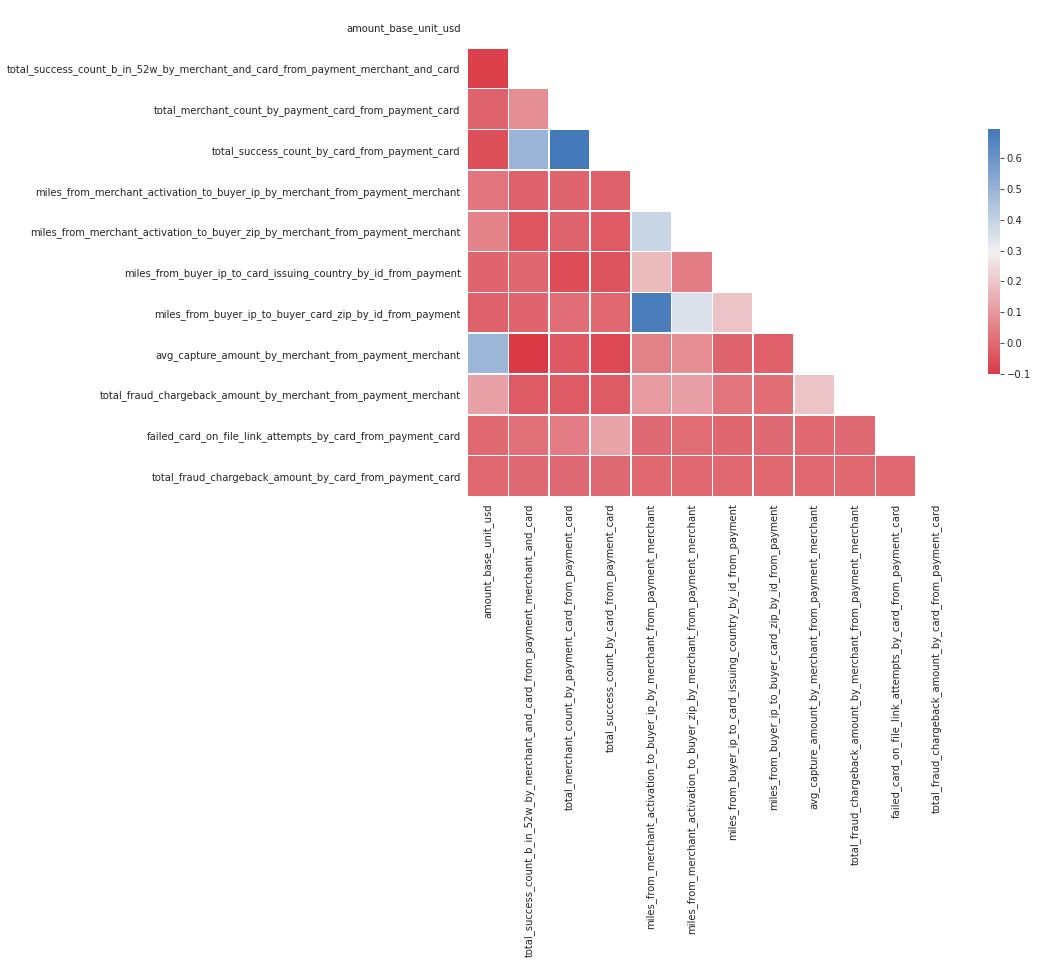

In [33]:

# use the pands .corr() function to compute pairwise correlations for the dataframe
corr = df_features.drop([ 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'avg_amount_by_merchant_from_payment_merchant'
      ,'last_to_avg_rate_by_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'miles_from_merchant_city_to_buyer_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_ip_by_id_from_payment'
      , 'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment' 
      , 'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment'
     ,  'successful_card_on_file_link_attempts_by_card_from_payment_card'], axis= 1).corr('pearson')
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [35]:
df_features.isna().sum(axis = 0)

df_features.drop([ 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'avg_amount_by_merchant_from_payment_merchant'
      ,'last_to_avg_rate_by_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'miles_from_merchant_city_to_buyer_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_ip_by_id_from_payment'
      , 'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment' 
      , 'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment'
     ,  'successful_card_on_file_link_attempts_by_card_from_payment_card'], axis= 1).isna().sum(axis=0)

payment_token                                                                            0
unit_token                                                                               0
business_name                                                                            0
best_available_merchant_token                                                            0
business_type                                                                            0
amount_bucket                                                                            0
is_chargebacked                                                                          0
risk_manager_enrolled                                                                    0
entry_method                                                                             0
amount_base_unit_usd                                                                     0
total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card         0

# XGBOOST

In [83]:
! pip install xgboost

Looking in indexes: https://pypi.org/simple, https://nexus3.sqcorp.co/repository/pypi-all/simple
     |████████████████████████████████| 157.5 MB 81 kB/s /s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [38]:
from sklearn import datasets
from xgboost import XGBClassifier
from xgboost import plot_tree

In [40]:
df_model = df_features.copy()
df_model.shape

(1524470, 31)

In [41]:
X = df_model.drop([
      'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'avg_amount_by_merchant_from_payment_merchant'
      ,'last_to_avg_rate_by_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'miles_from_merchant_city_to_buyer_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_ip_by_id_from_payment'
      , 'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment' 
      , 'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment'
      ,  'successful_card_on_file_link_attempts_by_card_from_payment_card'
      , 'is_chargebacked'
      , 'payment_token'
      , 'unit_token'
      , 'business_name'
      , 'best_available_merchant_token' 
      , 'amount_base_unit_usd'
      , 'total_fraud_chargeback_amount_by_merchant_from_payment_merchant'
      , 'risk_manager_enrolled'], axis= 1) # Features
y = df_model['is_chargebacked'].apply(lambda x: 0 if x == 'no' else 1) # Target variable

feature_cols = X.columns

from sklearn import preprocessing
number = preprocessing.LabelEncoder()
X['business_type'] = number.fit_transform(X.business_type)
X['amount_bucket'] = number.fit_transform(X.amount_bucket)
X['entry_method'] = number.fit_transform(X.entry_method)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [42]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

NameError: name 'xgb' is not defined

In [44]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'reg:linear',  
    'num_class': 2} 

steps = 20  # The number of training iterations
#model = xgb(param, D_train, steps)
model = XGBClassifier()


model.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:48:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(X_test)
#best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds = [round(value) for value in preds]

print("Precision = {}".format(precision_score(y_test, best_preds)))
print("Recall = {}".format(recall_score(y_test, best_preds)))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.5833333333333334
Recall = 0.05223880597014925
Accuracy = 0.9994227502017095


In [50]:
model.get_booster().get_score(importance_type="gain")

{'miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant': 6.3839956192444705,
 'miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment': 4.008630016226699,
 'avg_capture_amount_by_merchant_from_payment_merchant': 3.7379025897126925,
 'miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': 3.653143827379795,
 'amount_bucket': 5.305770055161539,
 'failed_card_on_file_link_attempts_by_card_from_payment_card': 3.3816140718571424,
 'miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment': 2.560870361040817,
 'total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card': 4.487781739167442,
 'business_type': 4.915647486694915,
 'total_success_count_by_card_from_payment_card': 3.1403404174099365,
 'total_merchant_count_by_payment_card_from_payment_card': 3.484472390996092,
 'entry_method': 3.92326081}

#    decision Tress

In [80]:
df_model = df_features.copy()
df_model = df_model.dropna()
df_model.shape

(84583, 31)

In [74]:
X = df_model.drop([
      'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'avg_amount_by_merchant_from_payment_merchant'
      ,'last_to_avg_rate_by_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant'
      , 'total_fraud_cnp_chargeback_count_by_card_from_payment_card'
      , 'miles_from_merchant_city_to_buyer_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_ip_by_id_from_payment'
      , 'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment'
      , 'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment' 
      , 'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment'
      ,  'successful_card_on_file_link_attempts_by_card_from_payment_card'
      , 'is_chargebacked'
      , 'payment_token'
      , 'unit_token'
      , 'business_name'
      , 'best_available_merchant_token' 
      , 'amount_base_unit_usd'
      , 'total_fraud_chargeback_amount_by_merchant_from_payment_merchant'
      , 'risk_manager_enrolled'], axis= 1) # Features
y = df_model['is_chargebacked'].apply(lambda x: 0 if x == 'no' else 1) # Target variable

feature_cols = X.columns

from sklearn import preprocessing
number = preprocessing.LabelEncoder()
X['business_type'] = number.fit_transform(X.business_type)
X['amount_bucket'] = number.fit_transform(X.amount_bucket)
X['entry_method'] = number.fit_transform(X.entry_method)
#X['risk_manager_enrolled'] = number.fit_transform(X.risk_manager_enrolled)
#y['is_chargebacked'] = number.fit_transform(y.is_chargebacked)
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [75]:
X.head()

,business_type,amount_bucket,entry_method,total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,total_merchant_count_by_payment_card_from_payment_card,total_success_count_by_card_from_payment_card,miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant,miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,avg_capture_amount_by_merchant_from_payment_merchant,failed_card_on_file_link_attempts_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card
1,12,1,0,1.00,1.00,1.00,27.74,27.75,0.00,3.56,3374.70,0.00,0.00
24,12,1,0,1.00,2.00,2.00,660.49,17.19,0.00,646.27,3014.11,0.00,0.00
33,12,1,0,4.00,2.00,9.00,119.18,6.40,0.00,125.52,3382.51,0.00,0.00
36,0,1,0,1.00,8.00,18.00,1.93,28.91,0.00,30.38,225.00,0.00,0.00
54,4,1,0,1.00,2.00,2.00,1128.78,7.37,0.00,1134.03,4127.06,0.00,0.00


In [70]:
sum(X['risk_manager_enrolled'] == 1)

8436

In [64]:
sum(y)

54

In [76]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [77]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9990541871921182


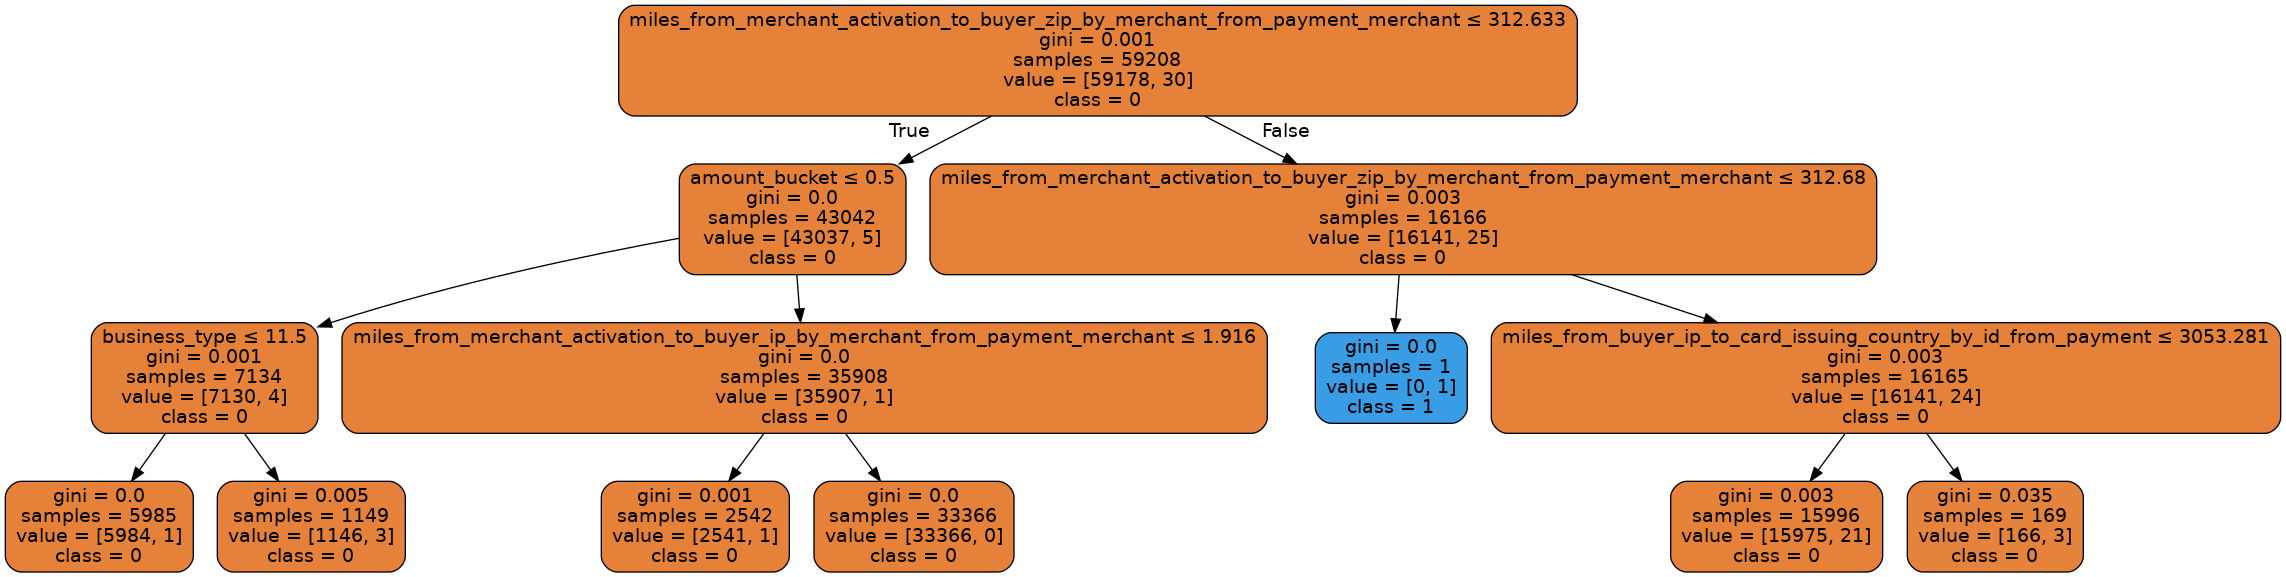

In [78]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from six import StringIO

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisionTree.png')
Image(graph.create_png())

# Dump

In [303]:


# Group the new features for all sellers by chargebacks
df_group_overall = df_features.groupby( [  'is_chargebacked'], #as_index=False
).agg(
    {
         '<2total_success_count_by_card_from_payment_card':sum,    
         '>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card':sum,  
         '>2xavg_capture_amount_by_merchant_from_payment_merchant': sum,      
         '>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment':sum,   
        
         '>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,  

         '>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>100miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,
        
                # combined signals
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount':sum,
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount':sum
        
    }
).T
df_group_overall.head(15)



is_chargebacked,no,yes
<2total_success_count_by_card_from_payment_card,162254,193
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,820283,204
>2xavg_capture_amount_by_merchant_from_payment_merchant,239622,395
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,24913,61
>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment,143194,136
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,159135,348
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,287817,242
>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant,175809,434
>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment,102371,252
>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment,202528,260


In [304]:
## % false positives of total payments and % of true positives of total payments
(df_group_overall/df_dumbo['payment_token'].count()*100).sort_values(by='no')

is_chargebacked,no,yes
>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount,1.09,0.01
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,1.68,0.00
>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount,2.70,0.01
>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment,6.91,0.02
>100miles_from_merchant_city_to_buyer_zip_by_id_from_payment,8.95,0.02
>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment,9.67,0.01
>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment,10.74,0.02
<2total_success_count_by_card_from_payment_card,10.95,0.01
>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant,11.87,0.03
>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment,13.67,0.02


In [306]:
columns= ('recall', 'precision')
df_pr_recall_overall = pd.DataFrame(index=df_group_overall.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall_overall['recall']=df_group_overall['yes']*100/sum(df_dumbo['is_chargebacked']=='yes')

##precision (charegacks detected of all payments flagged)
df_pr_recall_overall['precision'] = df_group_overall['yes']/(df_group_overall['yes']+df_group_overall['no'])*100

df_pr_recall_overall.sort_values(by=['recall'])

,recall,precision
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,7.20,0.24
>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount,13.22,0.69
>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment,16.06,0.09
<2total_success_count_by_card_from_payment_card,22.79,0.12
>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,24.09,0.02
>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount,25.86,0.54
>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,28.57,0.08
>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment,29.75,0.25
>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment,30.70,0.13
>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant,33.41,0.07


In [ ]:

df_features['total_success_count_by_card_from_payment_card'].apply(lambda x: 1 if x > 0 else 0).describe()

#df_group_overall.iloc[[df_group_overall['is_chargebacked'] == "yes"], 1:7]
df_group_overall[df_group_overall['is_chargebacked'] == 'no'].drop('is_chargebacked', axis=1)/df_dumbo['payment_token'].count()
#(df_group_overall.drop('is_chargebacked', axis=1)*1000/df_dumbo['payment_token'].count()).T

In [323]:
input_query = """select fpt.payment_token
                    , case when fpt.PAY_WITH_SQUARE_ENTRY_METHOD in ('EXTERNAL_API','EXTERNAL_API_ON_FILE', 'WEB_STORE_WEB_FORM','WEB_STORE_CARD_ON_FILE') then 'API' else 'eGC' end as entry_method
                from app_bi.pentagon.fact_payment_transactions fpt
                left join app_risk.app_risk.chargebacks c          
                on c.payment_token = fpt.payment_token   
                and  c.reason_code_type = 'fraud'
                join app_bi.pentagon.dim_user du
                on du.user_token = fpt.unit_token
                left join app_risk.app_risk.rm_enrolled_merchants rm
                on du.best_available_merchant_token = rm.merchant_token
                where fpt.PAY_WITH_SQUARE_ENTRY_METHOD in ('EXTERNAL_API','EXTERNAL_API_ON_FILE', 'EGIFT_PURCHASE_KEYED', 'WEB_STORE_WEB_FORM','WEB_STORE_CARD_ON_FILE'  )
                and PAYMENT_TRX_RECOGNIZED_AT between'2020-12-01' and '2020-12-31'
                and du.business_category = 'food_and_drink'
                """

with Session() as ss:
    df_payment_method = ss.execute(input_query)
df_payment_method.head()

#df_features1=df_features
df_features=df_features.merge(df_payment_method, "left", left_on='payment_token', right_on='payment_token')
df_features.shape


,payment_token,entry_method
0,p2RCdER40ODO9tascjQVxmPqQfVZY,API
1,rzZl4IzohFPlLvxUqz6XAI68uLXZY,API
2,PJJ4YXtZrUrM9iP2vVj8ROujUCdZY,API
3,HlrzrqWUDVYIpCPyuSboVbx3cqdZY,API
4,p2dWWv0Lv04EE4xrMer9d6QLLCcZY,API


In [365]:

# Group the new features for only RIsk Manager sellers by chargebacks
df_group_rm_entry = df_features[df_features['risk_manager_enrolled'] == 'yes'].groupby( [  'is_chargebacked','entry_method']
).agg(
    {
         '<2total_success_count_by_card_from_payment_card':sum,    
         '>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card':sum,  
         '>2xavg_capture_amount_by_merchant_from_payment_merchant': sum,      
         '>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment':sum,   
        
         '>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,  

         '>0total_fraud_chargeback_amount_by_merchant_from_payment_merchant':sum, 
         '>0total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant':sum,
         '>0total_fraud_chargeback_amount_by_card_from_payment_card': sum,  
         '>0total_fraud_cnp_chargeback_count_by_card_from_payment_card':sum,  
         '>0failed_card_on_file_link_attempts_by_card_from_payment_card': sum, 
         '>0successful_card_on_file_link_attempts_by_card_from_payment_card': sum, 
        
        
         '>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>100miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,  
        
        # combined signals
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount':sum,
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount':sum
        '>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount':sum
        '>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount'
        '>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount'
        df_features['>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount'] = \
(df_features['>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant'] == 1) & \
(df_features['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)


df_features['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount'] = \
(df_features['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)


df_features['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>3xavg_capture_amount'] = \
(df_features['>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)


df_features['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>2xavg_capture_amount'] = \
(df_features['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features['>2xavg_capture_amount_by_merchant_from_payment_merchant'] == True)


df_features['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment&&>3xavg_capture_amount'] = \
(df_features['>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment'] == 1) & \
(df_features['>3xavg_capture_amount_by_merchant_from_payment_merchant'] == True)
        
        
        
    }
).T


# Group the new features for only RIsk Manager sellers by chargebacks
df_group_rm = df_features[df_features['risk_manager_enrolled'] == 'yes'].groupby( [  'is_chargebacked']
).agg(
    {
         '<2total_success_count_by_card_from_payment_card':sum,    
         '>1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card':sum,  
         '>2xavg_capture_amount_by_merchant_from_payment_merchant': sum,      
         '>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment':sum,   
        
         '>250miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>250miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>250miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>250miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>250miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,  
        
        
         '>0total_fraud_chargeback_amount_by_merchant_from_payment_merchant':sum, 
         '>0total_fraud_cnp_chargeback_amount_by_merchant_from_payment_merchant':sum,
         '>0total_fraud_chargeback_amount_by_card_from_payment_card': sum,  
         '>0total_fraud_cnp_chargeback_count_by_card_from_payment_card':sum,  
         '>0failed_card_on_file_link_attempts_by_card_from_payment_card': sum, 
         '>0successful_card_on_file_link_attempts_by_card_from_payment_card': sum, 
        
        

         '>100miles_from_merchant_city_to_buyer_ip_by_id_from_payment':sum, 
         '>100miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment':sum,
         '>100miles_from_merchant_activation_to_buyer_ip_by_merchant_from_payment_merchant': sum,  
         '>100miles_from_merchant_activation_to_buyer_zip_by_merchant_from_payment_merchant':sum,  
         '>100miles_from_merchant_city_to_buyer_zip_by_id_from_payment': sum,  
        
        # combined signals
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount':sum,
        '>100miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount':sum
        '>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>2xavg_capture_amount':sum,
        '>250miles_from_merchant_activation_to_buyer_zip_by_merchant&&>3xavg_capture_amount':sum
        
    }
).T

df_group_rm_entry.head(100)

SyntaxError: invalid syntax (<ipython-input-365-8fcbede16d80>, line 74)